> 영상의 meta, 프리티스케일 점수 피처 EDA와 전처리 작업 코드입니다. 

> 참고 : Cell의 Output에 VideoId, ChannelId 등 개인정보가 포함된 경우 개인정보 보호를 위해 Output을 삭제하였습니다.

## 0. [기본] 데이터 불러오기, 결측치 확인
* 결측치 컬럼 1. 설명 -> 설명 컬럼 삭제
* 결측치 컬럼 2. 태그 -> 갯수로 변환, 결측치는 0으로 변환

In [450]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("final.csv")
data.drop('Unnamed: 0', axis = 1, inplace = True) # 저장할 때 생긴 인덱스 컬럼 삭제

data.head(2)

In [508]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186 entries, 0 to 2185
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   channelId     2186 non-null   object 
 1   channelTitle  2186 non-null   object 
 2   videoId       2186 non-null   object 
 3   duration      2186 non-null   int64  
 4   viewCount     2186 non-null   int64  
 5   paidBadge     2186 non-null   int64  
 6   bday          2186 non-null   int64  
 7   subs          2186 non-null   int64  
 8   gender        2186 non-null   object 
 9   prettyScale   2186 non-null   float64
 10  publishedAt   2186 non-null   int64  
 11  videoTitle    2186 non-null   object 
 12  desc          1415 non-null   object 
 13  tag           942 non-null    object 
dtypes: float64(1), int64(6), object(7)
memory usage: 239.2+ KB


> 데이터프레임 info 확인 결과 설명과 태그 컬럼에 결측치가 있는 것으로 확인되었습니다. 영상 설명 컬럼은 광고 영상 판별 여부를 위해 추가된 컬럼이며 모델링에는 필요하지 않으므로 드랍하는 것으로 처리하겠습니다. 태그 컬럼의 경우 태그의 갯수(int)로 변환하여 결측치 row는 0으로 처리하겠습니다.

In [509]:
# 설명 컬럼 drop

data.drop('desc', axis = 1, inplace = True)

In [510]:
# 태그 컬럼 -> 태그 갯수로 변환

data['tag'].apply(lambda x: 0 if str(x) == 'nan' else str(x).count(',')+1)

0        0
1        0
2       34
3       34
4       34
        ..
2181     0
2182    33
2183    56
2184    23
2185    43
Name: tag, Length: 2186, dtype: int64

In [511]:
data['tag'] = data['tag'].apply(lambda x: 0 if str(x) == 'nan' else str(x).count(',')+1)

In [ ]:
data.head(3)

## 1. 불필요한 컬럼 삭제
* 채널타이틀 삭제

In [ ]:
# 필요없는 컬럼 삭제 (채널명)

def drop_columns(df_input):
    df = df_input.copy()
    df.drop(['channelTitle'], axis = 1, inplace = True)
    return df

data = drop_columns(data)
data.head()

## 2. 구독자 수 로그화

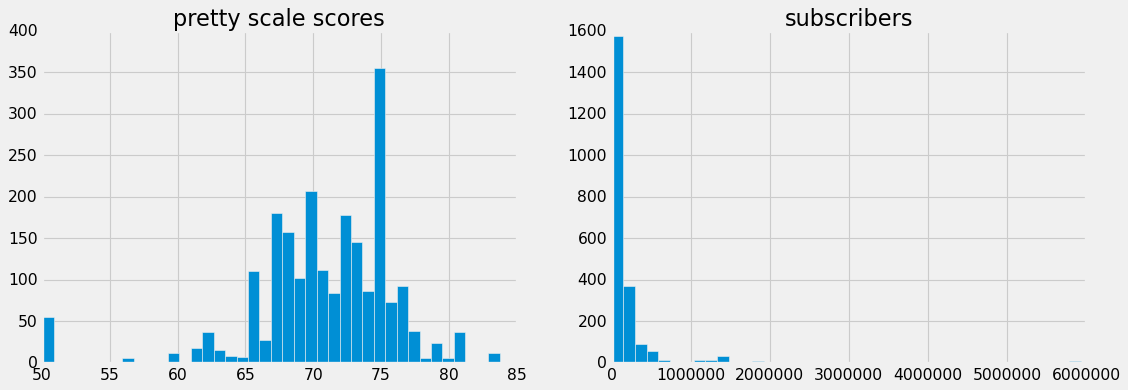

In [514]:
plt.style.use('fivethirtyeight')

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.hist(data['prettyScale'], bins = 40)
plt.title('pretty scale scores')

plt.subplot(1, 2, 2)
plt.hist(data['subs'], bins = 40)
plt.title('subscribers')

plt.show()

> 프리티스케일 점수의 분포는 대체로 정규분포 모양을 따르는 것으로 확인되었으나, 구독자는 좌편향이 매우 심한것으로 확인되어 조금 더 자세히 살펴보도록 하겠습니다.

In [515]:
data['subs'].sort_values(ascending = False)

0       5930000
1487    5930000
1488    5930000
1489    5930000
1490    5930000
         ...   
494          71
490          71
491          71
492          71
493          71
Name: subs, Length: 2186, dtype: int64

> 구독자 수의 최댓값은 약 600만, 최솟값은 71로 편차가 매우 큰 것으로 확인됩니다.

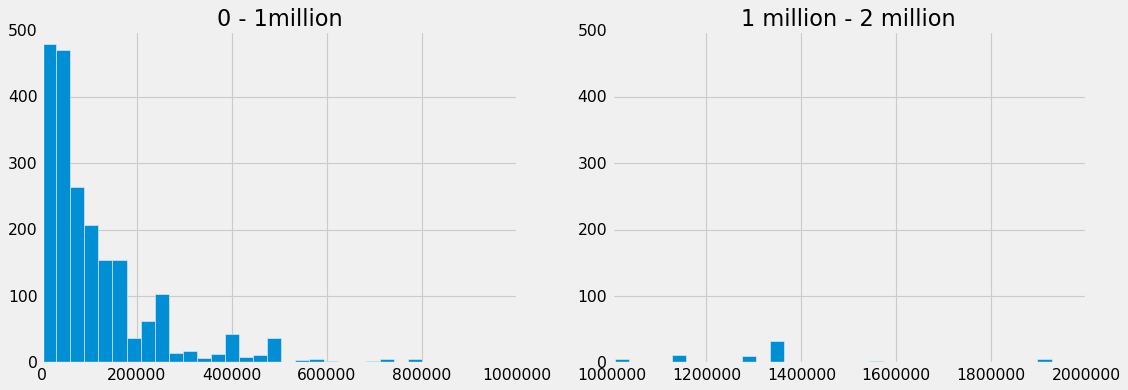

In [516]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.hist(data = data, x = 'subs', bins = 200)
plt.xlim(0, 1000000)
plt.title("0 - 1million")

plt.subplot(1, 2, 2)
plt.hist(data = data, x = 'subs', bins = 200)
plt.xlim(1000000, 2000000)
plt.title("1 million - 2 million")
plt.show()

> 구독자 수는 대체로 20만 이하에 집중 분포하고 있는 것으로 확인됩니다. 컬럼을 로그화 / MinMaxScaler 정규화를 했을 때 분포가 어떻게 다른지 살펴보겠습니다

In [517]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0.5, 0.98, 'subscribers')

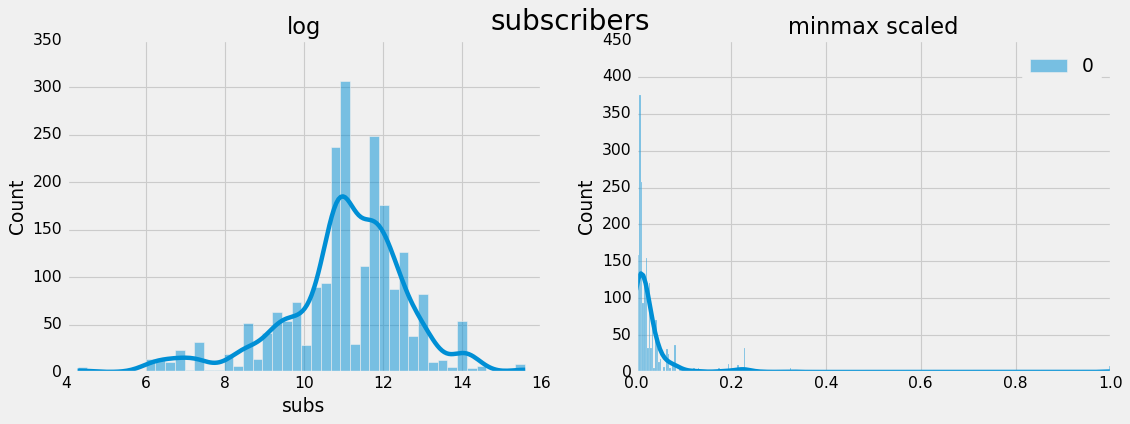

In [518]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['subs'].apply(np.log1p), kde = True)
plt.title("log")

plt.subplot(1, 2, 2)
scale = MinMaxScaler()
sns.histplot(scale.fit_transform(data[['subs']]), kde = True)
plt.title("minmax scaled")

plt.suptitle("subscribers", fontsize = 25)


> 로그를 취할 경우 그래프가 좀 더 정규분포를 따르도록 보정되고, minmax scaled를 취할 경우 범위의 변화만 있을 뿐 그래프의 형태에는 큰 변화가 없습니다. 정상적인 학습 진행을 위해 구독자 수에는 자연로그를 취해 보정을 먼저 진행한 다음 정규화를 하도록 하겠습니다.

In [519]:
# 구독자 수 로그화 진행

def log(df_input) :
    df = df_input.copy()

    # 구독자 수 자연로그 취하기
    df['subs'] = df['subs'].apply(np.log1p)

    return df

In [ ]:
data = log(data)

## 3. 젠더 컬럼 Encoding / 타이틀 길이 추가
* Female 1
* Male 0

In [521]:
data['gender'].value_counts()

gender
F     1938
M      185
F       63
Name: count, dtype: int64

> F가 공백이 들어갔는지 2개로 나뉘어 있으므로, M이 아닌 값은 전부 'F'로 통일하겠습니다.

In [522]:
data['gender'] = data['gender'].apply(lambda x: 'F' if x != 'M' else 'M')

In [523]:
data['gender'].value_counts()

gender
F    2001
M     185
Name: count, dtype: int64

In [ ]:
data.set_index(['gender', 'videoId']).sort_index()

In [525]:
data[data['gender'] == 'M']['viewCount'].sort_values(ascending = False)

579     8127613
566     1957831
530     1511072
1175    1221321
533      926154
         ...   
1268        238
1271        220
1266        203
1265        169
1276        121
Name: viewCount, Length: 185, dtype: int64

In [526]:
data[data['gender'] == 'F']['viewCount'].sort_values(ascending = False)

588    16253900
584     6540535
600     6305408
597     5757890
580     4489543
         ...   
926          41
957          40
624          36
625          36
931          33
Name: viewCount, Length: 2001, dtype: int64

> 여성 데이터가 약 11배 이상, 조회수의 분포도 더 넓고 높은 것으로 확인됩니다. 여성 데이터에 가중치를 주기 위해 F를 1로, M를 0으로 변환하겠습니다.

In [ ]:
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'F' else 0)

data.head()

In [528]:
# 타이틀 길이

data['videoTitle'] = data['videoTitle'].apply(len)

<Axes: xlabel='videoTitle', ylabel='Count'>

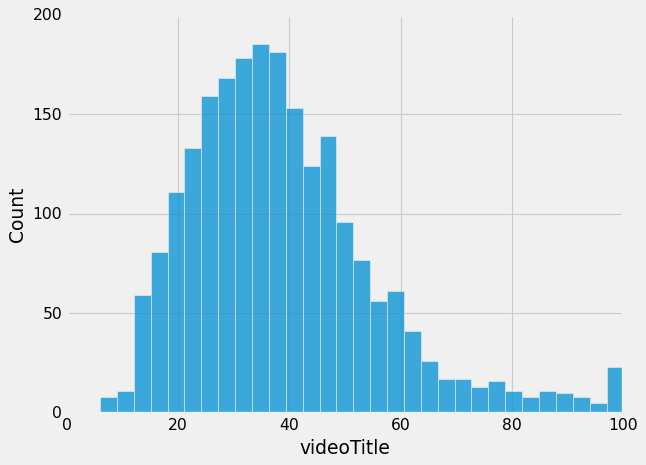

In [531]:
sns.histplot(data['videoTitle'])

## 4. MinMaxScaler 정규화
* bday 컬럼 : 채널 개설일로부터 지금까지 일수
* publishedAt 컬럼 : 영상 게시일로부터 지금까지 일수
* prettyScale 컬럼 : 프리티스케일 점수
* subs 컬럼 : 로그화된 구독자 수
* videoTitle 컬럼 : 타이틀 길이

#### prettyscale 컬럼 상세 확인

In [53]:
df['prettyScale'].describe()

count   2186.000
mean      70.882
std        5.318
min       50.000
25%       68.250
50%       71.500
75%       75.000
max       83.750
Name: prettyScale, dtype: float64

In [55]:
# 이상치

q1 = df['prettyScale'].quantile(0.25)
q2 = df['prettyScale'].quantile(0.50)
q3 = df['prettyScale'].quantile(0.75)
iqr = q3 - q1

outliers_tag_index_up = df[df['prettyScale'] > q3 + 1.5 * iqr].index.tolist()
outliers_tag_index_down = df[df['prettyScale'] < q1 - 1.5 * iqr].index.tolist()

In [57]:
len(outliers_tag_index_down)

60

In [58]:
len(outliers_tag_index_up)

0

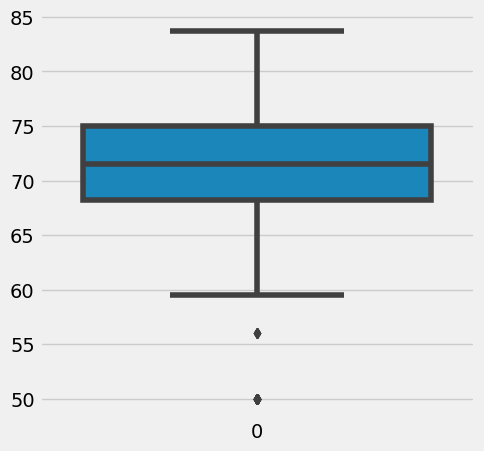

In [61]:
plt.figure(figsize = (5,5))
sns.boxplot(df['prettyScale'])
plt.show()

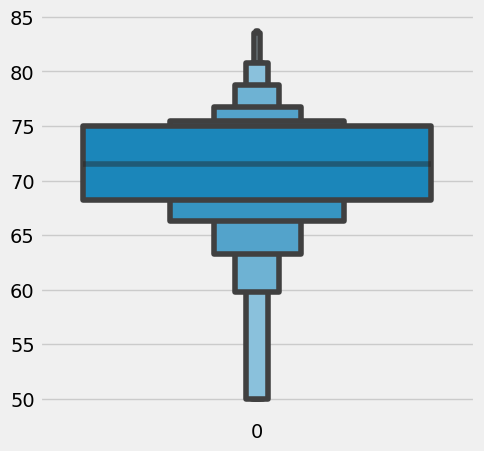

In [62]:
plt.figure(figsize = (5,5))
sns.boxenplot(df['prettyScale'])
plt.show()

In [73]:
df.iloc[outliers_tag_index_down]['channelTitle'].unique()

array(['오늘의 립', 'KoreanDobby 코리안도비', '시네 si-ne'], dtype=object)

> 하위 아웃라이어 60개의 주인공은 3명의 유투버로, 외모 점수에 따른 모델링 결과 후 분석이 궁금하므로 아웃라이어를 그대로 두고 진행하겠음

#### 다른 컬럼 확인

Text(0.5, 1.0, 'subs')

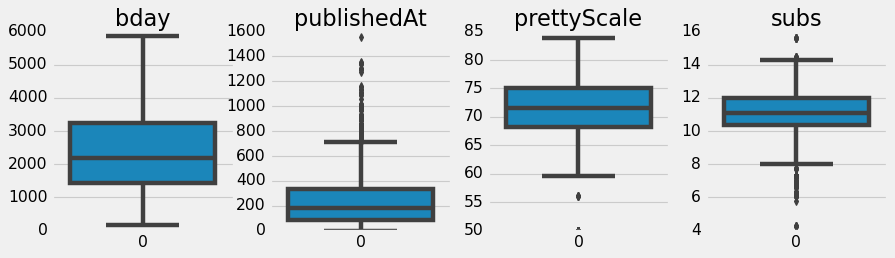

In [302]:
plt.figure(figsize = (12, 3))

plt.subplot(1,4,1)
sns.boxplot(data['bday'])
plt.title('bday')

plt.subplot(1,4,2)
sns.boxplot(data['publishedAt'])
plt.title('publishedAt')

plt.subplot(1,4,3)
sns.boxplot(data['prettyScale'])
plt.title('prettyScale')

plt.subplot(1,4,4)
sns.boxplot(data['subs'])
plt.title('subs')

Text(0.5, 1.0, 'subs')

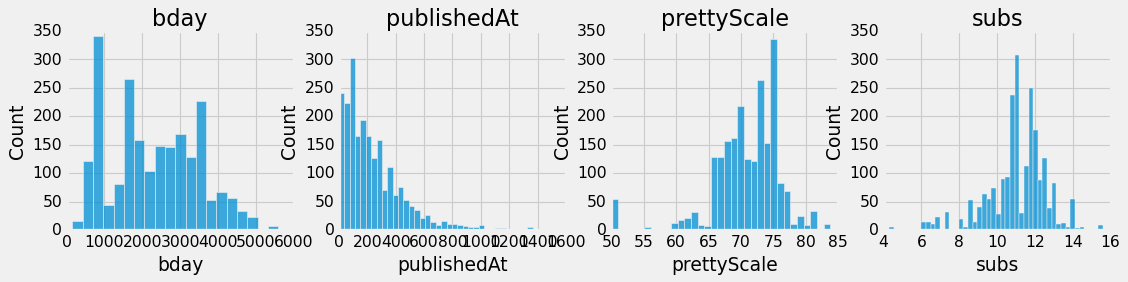

In [303]:
plt.figure(figsize = (15, 3))

plt.subplot(1,4,1)
sns.histplot(data['bday'])
plt.title('bday')

plt.subplot(1,4,2)
sns.histplot(data['publishedAt'])
plt.title('publishedAt')

plt.subplot(1,4,3)
sns.histplot(data['prettyScale'])
plt.title('prettyScale')

plt.subplot(1,4,4)
sns.histplot(data['subs'])
plt.title('subs')

In [532]:
# 4개 컬럼 MinMaxScaler 이용해서 0-1 사이로 정규화 진행

minmax_scaler = MinMaxScaler()

In [534]:
normalized = pd.DataFrame(minmax_scaler.fit_transform(data[['duration', 'bday', 'publishedAt', 'prettyScale', 'subs', 'videoTitle']]),
                                                  columns = ['duration', 'bday', 'publishedAt', 'prettyScale', 'subs', 'videoTitle'])

normalized.head()

,duration,bday,publishedAt,prettyScale,subs,videoTitle
0,0.981818,0.567227,0.140283,1.000000,1.000000,0.255319
1,0.618182,0.567227,0.119048,1.000000,1.000000,0.180851
2,0.727273,0.484769,0.438224,0.911111,0.869252,0.223404
3,0.636364,0.484769,0.383526,0.911111,0.869252,0.127660
4,0.436364,0.484769,0.312098,0.911111,0.869252,0.382979


In [535]:
for column in ['duration', 'bday', 'publishedAt', 'prettyScale', 'subs', 'videoTitle']:
    data[column] = normalized[column]

## 5. 태그컬럼 이상치 제거, RobustScaler + MinMaxScaler정규화

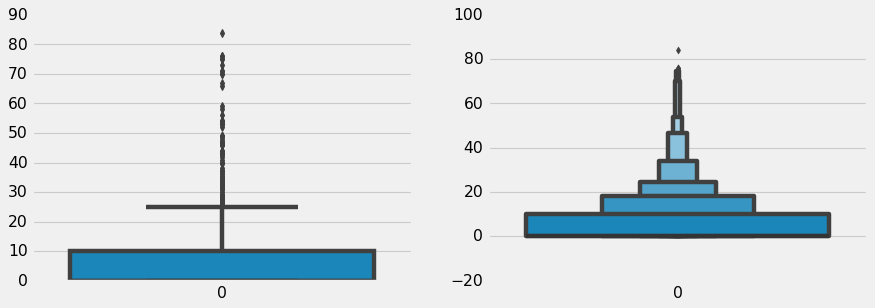

In [537]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data['tag'])

plt.subplot(1, 2, 2)
sns.boxenplot(data['tag'])

plt.show()

<Axes: xlabel='tag', ylabel='viewCount'>

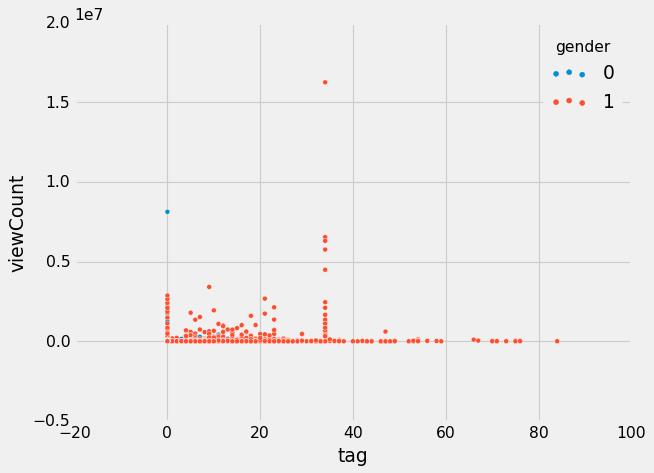

In [538]:
sns.scatterplot(data = data,
                x = 'tag',
                y = 'viewCount',
               hue = 'gender')

> 태그 컬럼의 경우 이상치가 많이 분포하고 있습니다. 또, 태그의 갯수가 많다고 해서 조회수가 많은 양의 선형관계를 가지고 있지 않으므로, 태그의 경우 MinMaxScaler을 사용해서 정규화를 하면 안될 것 같습니다.
>
> 태그 컬럼의 이상치 로우를 구해보겠습니다.

In [539]:
data['tag'].describe()

count    2186.000000
mean        6.657365
std        11.217353
min         0.000000
25%         0.000000
50%         0.000000
75%        10.000000
max        84.000000
Name: tag, dtype: float64

In [540]:
# 이상치 구하기

q1 = data['tag'].quantile(0.25)
q2 = data['tag'].quantile(0.50)
q3 = data['tag'].quantile(0.75)

print(q1, q2, q3)

iqr = q3 - q1
print(iqr)

0.0 0.0 10.0
10.0


In [ ]:
data[data['tag'] > q3 + 1.5 * iqr].sort_values('viewCount', ascending = False)

> 기본 weight(1.5로 구한 tag컬럼의 이상치 로우는 총 125개입니다. 125개 로우에 대해서 태그 갯수의 값을 평균값으로 바꾸어 주겠습니다.)

In [542]:
outliers_tag_index = data[data['tag'] > q3 + 1.5 * iqr].index.tolist()
tag_mean = data['tag'].mean()

print(tag_mean, len(outliers_tag_index))

6.6573650503202195 125


In [543]:
# 평균값으로 바꾸어주기

for i in outliers_tag_index:
    data.at[i, 'tag'] = tag_mean

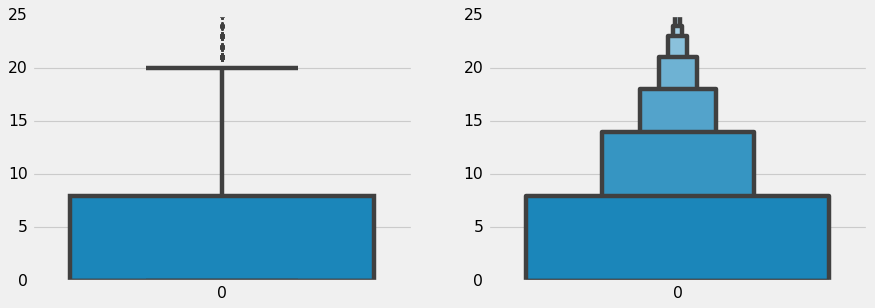

In [544]:
# 이상치 처리 후 분포도 시각화

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data['tag'])

plt.subplot(1, 2, 2)
sns.boxenplot(data['tag'])

plt.show()

<Axes: xlabel='tag', ylabel='viewCount'>

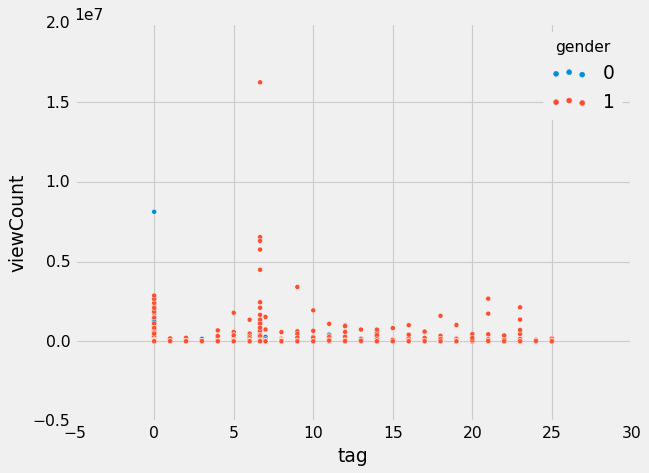

In [545]:
sns.scatterplot(data = data,
                x = 'tag',
                y = 'viewCount',
               hue = 'gender')

In [ ]:
# 이상치 구하기

q1 = data['tag'].quantile(0.25)
q2 = data['tag'].quantile(0.50)
q3 = data['tag'].quantile(0.75)

print(q1, q2, q3)

iqr = q3 - q1
print(iqr)

data[data['tag'] > q3 + 1.5 * iqr].sort_values('viewCount', ascending = False)

> 기본 웨이트로 이상치를 제거하고 난 이후에도 여전히 72개의 이상치가 발견됩니다. 따라서 tag 컬럼은 이상치에 대한 저항을 가진 RobustScaler를 적용해서 정규화를 진행하겠습니다.

In [547]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

In [548]:
robusted = rs.fit_transform(data[['tag']])

In [549]:
robusted

array([[0.        ],
       [0.        ],
       [0.83217063],
       ...,
       [0.83217063],
       [2.875     ],
       [0.83217063]])

In [550]:
data['tag'] = robusted

<Axes: xlabel='tag', ylabel='Count'>

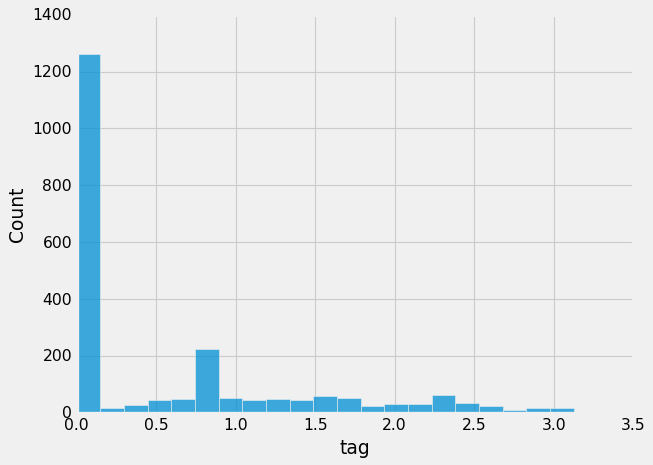

In [488]:
sns.histplot(data['tag'])

> 마지막으로 다른 컬럼보다 가중치를 받는 일이 없도록 minmaxscaler로 한번 더 정규화 작업을 통해 값을 0과 1 사이로 만들겠습니다.

In [551]:
scale = MinMaxScaler()
scaled = scale.fit_transform(data[['tag']])

scaled

array([[0.       ],
       [0.       ],
       [0.2662946],
       ...,
       [0.2662946],
       [0.92     ],
       [0.2662946]])

In [552]:
data['tag'] = scaled

<Axes: xlabel='tag', ylabel='Count'>

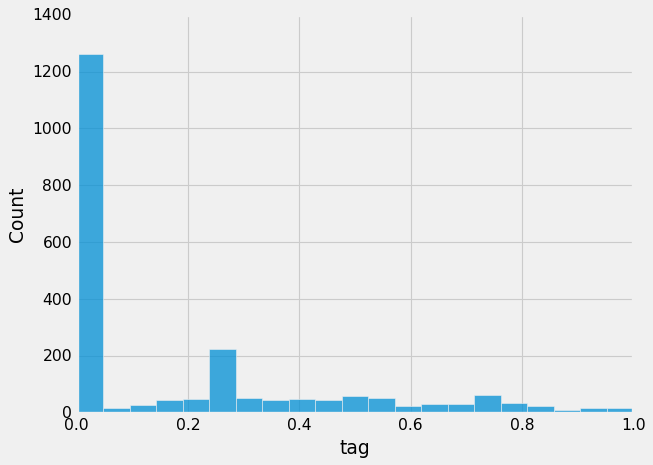

In [553]:
sns.histplot(data['tag'])

In [ ]:
data

## 6. 메타데이터 상관계수 확인

In [557]:
meta = data.drop(['channelId', 'videoId', 'prettyScale'], axis = 1)

In [558]:
meta['view'] = meta['viewCount']

In [559]:
meta.drop('viewCount', axis = 1, inplace = True)

In [560]:
meta

,duration,paidBadge,bday,subs,gender,publishedAt,videoTitle,tag,view
0,0.981818,1,0.567227,1.000000,1,0.140283,0.255319,0.000000,113589
1,0.618182,1,0.567227,1.000000,1,0.119048,0.180851,0.000000,175305
2,0.727273,1,0.484769,0.869252,1,0.438224,0.223404,0.266295,442609
3,0.636364,1,0.484769,0.869252,1,0.383526,0.127660,0.266295,1102446
4,0.436364,1,0.484769,0.869252,1,0.312098,0.382979,0.266295,1663662
...,...,...,...,...,...,...,...,...,...
2181,0.981818,1,0.251576,0.566175,1,0.274131,0.234043,0.000000,6609
2182,0.890909,1,0.827731,0.557694,1,0.173745,0.212766,0.266295,328
2183,0.709091,1,0.827731,0.557694,1,0.459459,0.127660,0.266295,28383
2184,0.945455,1,0.827731,0.557694,1,0.466538,0.500000,0.920000,1984


In [561]:
meta.corr()

,duration,paidBadge,bday,subs,gender,publishedAt,videoTitle,tag,view
duration,1.000000,0.026736,0.049220,0.054416,-0.063680,-0.090532,0.138815,0.087722,-0.060315
paidBadge,0.026736,1.000000,-0.144650,0.079002,-0.115157,-0.172340,-0.022491,-0.129276,-0.114574
bday,0.049220,-0.144650,1.000000,0.215417,0.052846,0.150908,-0.056042,0.107222,0.018375
subs,0.054416,0.079002,0.215417,1.000000,0.170324,-0.020286,-0.017950,-0.068514,0.211703
gender,-0.063680,-0.115157,0.052846,0.170324,1.000000,0.030475,0.152745,0.067045,-0.001096
publishedAt,-0.090532,-0.172340,0.150908,-0.020286,0.030475,1.000000,0.030608,0.200321,0.098318
videoTitle,0.138815,-0.022491,-0.056042,-0.017950,0.152745,0.030608,1.000000,0.056343,-0.042436
tag,0.087722,-0.129276,0.107222,-0.068514,0.067045,0.200321,0.056343,1.000000,0.003837
view,-0.060315,-0.114574,0.018375,0.211703,-0.001096,0.098318,-0.042436,0.003837,1.000000


<Axes: >

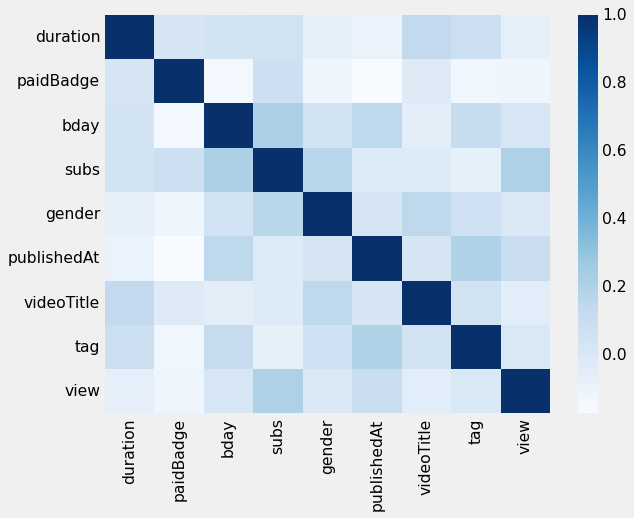

In [562]:
sns.heatmap(meta.corr(), cmap = 'Blues')

> 메타데이터의 상관계수는 구독자가 가장 높고, 나머지는 작음. 조회수를 로그화 해서 다시 확인해 보겠음.

In [563]:
meta['view'] = meta['view'].apply(np.log1p)

In [564]:
meta.corr()

,duration,paidBadge,bday,subs,gender,publishedAt,videoTitle,tag,view
duration,1.000000,0.026736,0.049220,0.054416,-0.063680,-0.090532,0.138815,0.087722,0.020497
paidBadge,0.026736,1.000000,-0.144650,0.079002,-0.115157,-0.172340,-0.022491,-0.129276,0.056456
bday,0.049220,-0.144650,1.000000,0.215417,0.052846,0.150908,-0.056042,0.107222,-0.075468
subs,0.054416,0.079002,0.215417,1.000000,0.170324,-0.020286,-0.017950,-0.068514,0.613553
gender,-0.063680,-0.115157,0.052846,0.170324,1.000000,0.030475,0.152745,0.067045,0.054215
publishedAt,-0.090532,-0.172340,0.150908,-0.020286,0.030475,1.000000,0.030608,0.200321,0.130978
videoTitle,0.138815,-0.022491,-0.056042,-0.017950,0.152745,0.030608,1.000000,0.056343,0.015297
tag,0.087722,-0.129276,0.107222,-0.068514,0.067045,0.200321,0.056343,1.000000,-0.092042
view,0.020497,0.056456,-0.075468,0.613553,0.054215,0.130978,0.015297,-0.092042,1.000000


<Axes: >

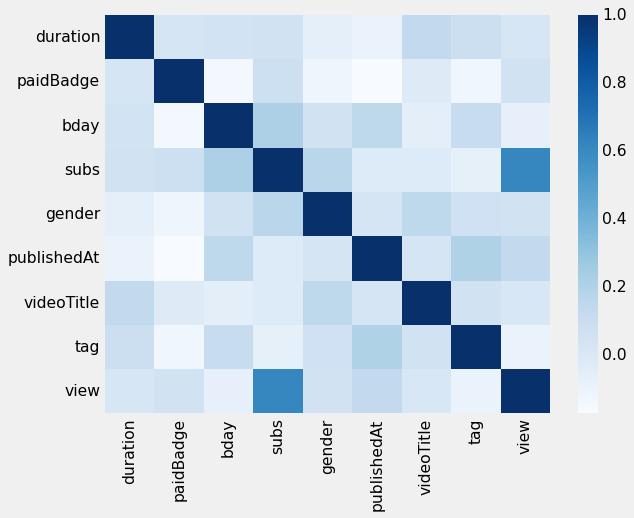

In [565]:
sns.heatmap(meta.corr(), cmap = 'Blues')

> 구독자수 상관계수가 더욱 높아졌음. 조회수에 로그를 취해서 회귀 예측을 하는것이 좋을 것으로 보임. 그 전에 시각화 작업으로 확인 후 처리하겠습니다.

## 7. 로그 조회수 컬럼 추가, csv파일로 내보내기

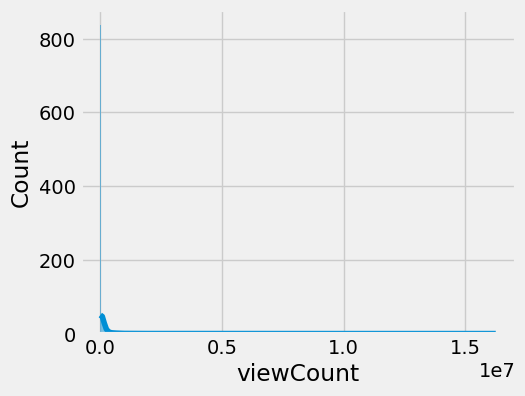

In [39]:
plt.figure(figsize = (5, 4))
sns.histplot(df['viewCount'], kde = True)
plt.show()

In [16]:
pd.options.display.float_format = '{:.3f}'.format

In [17]:
df['viewCount'].describe()

count       2184.000
mean      114550.326
std       531548.441
min           33.000
25%         3342.250
50%        15116.000
75%        54497.500
max     16253900.000
Name: viewCount, dtype: float64

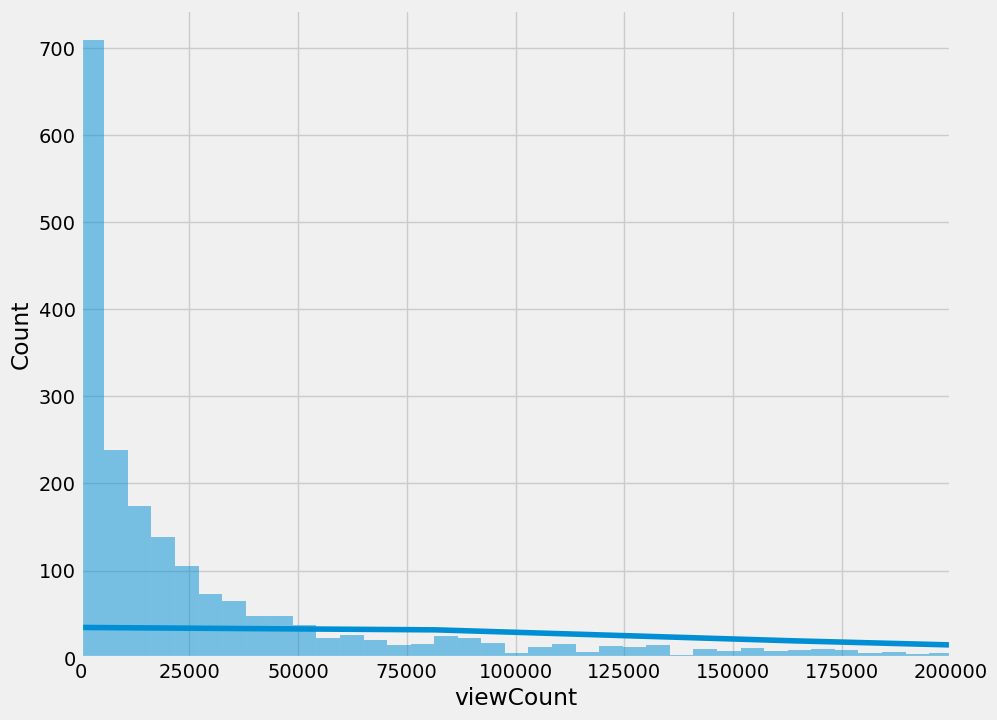

In [35]:
# x축 범위 20만으로 제한

plt.figure(figsize = (10, 8))
sns.histplot(df['viewCount'], bins = 3000, kde = True)
plt.xlim(0, 200000)
plt.show()

In [566]:
# 로그 조회수 추가

data['viewCount_log'] = data['viewCount'].apply(np.log1p)

<Axes: xlabel='viewCount', ylabel='Count'>

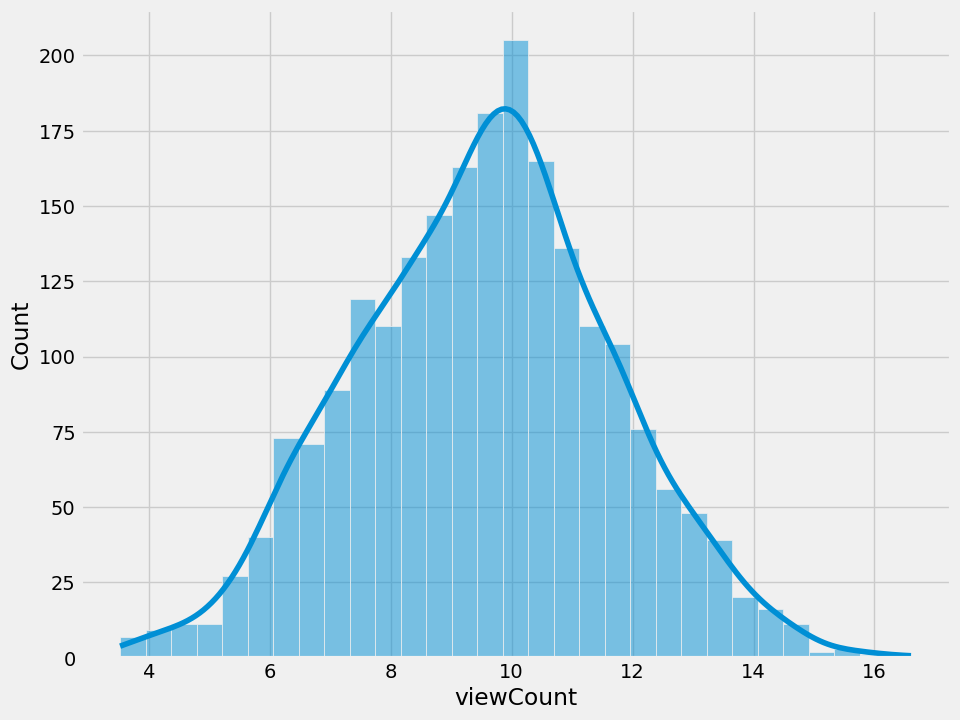

In [43]:
plt.figure(figsize = (10, 8))
sns.histplot(data['viewCount_log']), kde = True)

In [46]:
df['viewCount'].apply(np.log1p).describe()

count   2184.000
mean       9.542
std        2.111
min        3.526
25%        8.115
50%        9.624
75%       10.906
max       16.604
Name: viewCount, dtype: float64

In [506]:
data.to_csv("기본전처리완료_조회수로그화_타이틀길이추가.csv", index = False)